# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

## Objectives 

1. **Your primary objective is to develop an approach to detect the beginning of the “faulty” period**. Ideally, this approach would give the ExampleCo engineers as much time as possible to shut down their machines before failure occurs (at which time all measurements drop close to 0). The best solutions are automated in the sense that they would generalize to similar but slightly different data; simpler methods are acceptable but are less likely to receive full credit.
2. Demonstrate the efficacy of your approach using visualizations. You must also include a simple explanation of these figures and why your approach is effective, ideally written in language that non-technical executives could understand.
3. Finally, and now with a technical audience in mind, discuss the strengths and limitations of your approach and be sure to mention other approaches that you would have liked to try if you had more time.


## Notes to help
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like. Your final results should be
   presented in this Python notebook.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. **Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted**. In particular, you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

# My solution(s)

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from ipywidgets import interact
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import tensorflow as tf

%matplotlib inline

# Let's start with an EDA of all the data

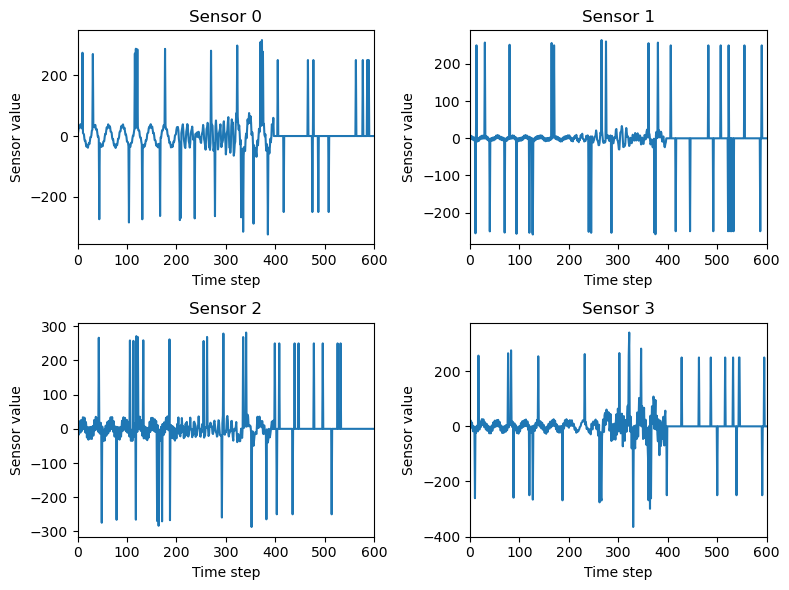

In [2]:
def plot_data(machine=0,percent=20):
    
    data = pd.read_csv("data/machine_"+str(machine)+".csv", index_col=0)

    #plot
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))

    for i in range(4):
        
        ax[i//2, i%2].plot(range(len(data)), data[str(i)])
        ax[i//2, i%2].set_xlim(0, len(data)*percent/100)
        ax[i//2, i%2].set_xlabel('Time step')
        ax[i//2, i%2].set_ylabel('Sensor value')
        ax[i//2, i%2].set_title('Sensor '+str(i))
        
    plt.tight_layout()
    plt.show()

plot_data(machine=0, percent=20)

Scrolling through all the machines, we see that there are massive spikes due to the communications errors that mask out the signal. We need to remove these first. Since all the spikes occur over a value of 100, we can simply remove these values and replace them with a linear interpolation of the neighboring values

### Removing spikes

In [3]:
def remove_spikes(data):

    cutoff = 100
    data[abs(data)>cutoff] = np.nan
    data = data.interpolate()
    data = data.fillna(0)

    return data

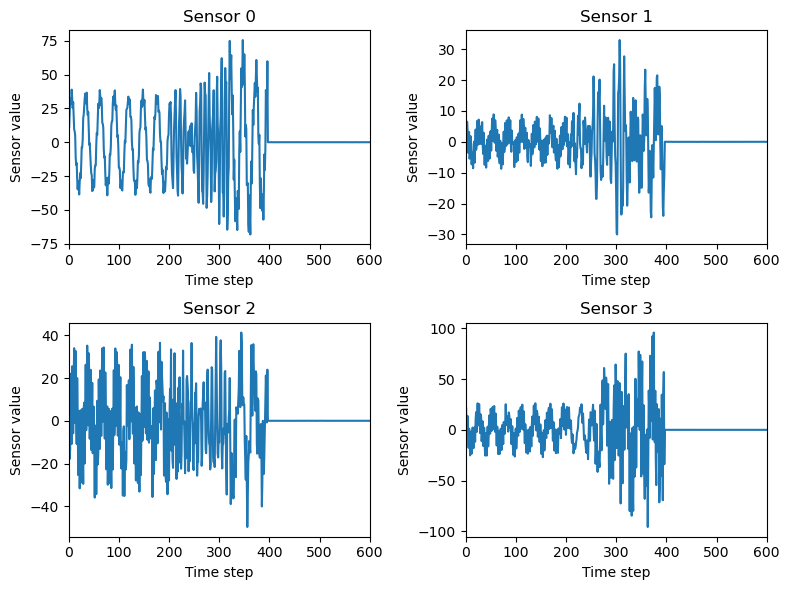

In [4]:
def plot_data_without_spikes(machine=0,percent=20):
    
    data = pd.read_csv("data/machine_"+str(machine)+".csv", index_col=0)

    #plot
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))

    for i in range(4):
        
        ax[i//2, i%2].plot(range(len(data)), remove_spikes(data[str(i)]))
        ax[i//2, i%2].set_xlim(0, len(data)*percent/100)
        ax[i//2, i%2].set_xlabel('Time step')
        ax[i//2, i%2].set_ylabel('Sensor value')
        ax[i//2, i%2].set_title('Sensor '+str(i))
        
    plt.tight_layout()
    plt.show()

plot_data_without_spikes(machine=0, percent=20)

If we plot only around 20% of the data, we see that the signals from most sensors and machines are generally oscillatory, but there is also a high frequency component to the signals we might want to smooth over. Let's do this by simply taking a moving average.

### Smoothing the data

In [5]:
def smooth_data(data, window=10):
    return data.rolling(window=window, min_periods=1).mean()

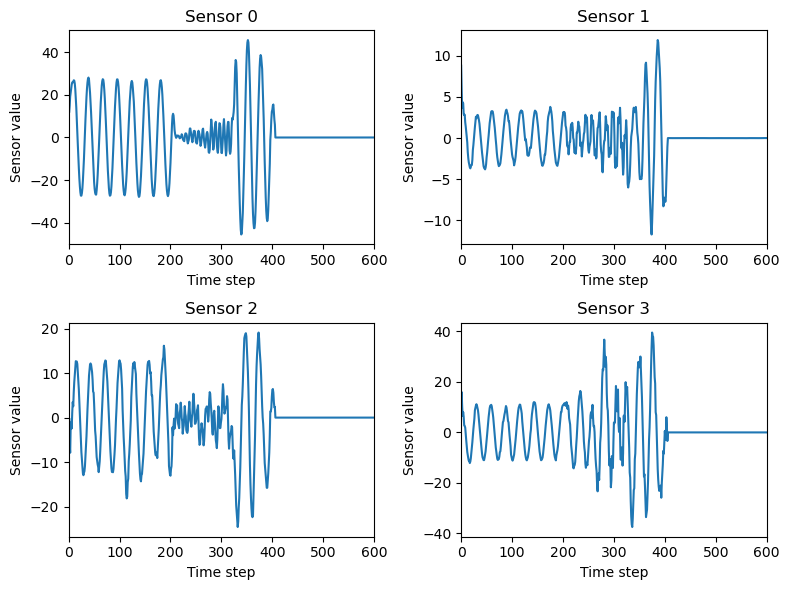

In [6]:
def plot_data_cleaned(machine=0,percent=20):
    
    data = pd.read_csv("data/machine_"+str(machine)+".csv", index_col=0)
    clean_data = smooth_data(remove_spikes(data))

    #plot
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))

    for i in range(4):
            
        ax[i//2, i%2].plot(range(len(data)), clean_data[str(i)])
        ax[i//2, i%2].set_xlim(0, len(data)*percent/100)
        ax[i//2, i%2].set_xlabel('Time step')
        ax[i//2, i%2].set_ylabel('Sensor value')
        ax[i//2, i%2].set_title('Sensor '+str(i))
        
    plt.tight_layout()
    plt.show()

plot_data_cleaned(machine=0, percent=20)

That's much better. <br />
At this stage it's clear that there are 3 modes of operation: *normal, faulty*, and *failed*. <br /> 
These seem to be characterized as follows:
* Normal mode: oscillatory with constant frequency and amplitude
* Faulty mode: oscillatory, but with highly varying amplitude/frequency
* Failed mode: near zero signal

<br />
Now, we need to build a model that can tell us the operating mode of the system. 

# Approach 1: Spectrogram

Since we do not have labelled data, we need to use some form of unsupervised learning. <br />
One option is to take batches of the data and see how they relate to each other. Given the nature of the data, we care about variations in frequency and aplitude over time. This suggests that a spectrogram would be a good representation.

### Visualizing the spectrogram

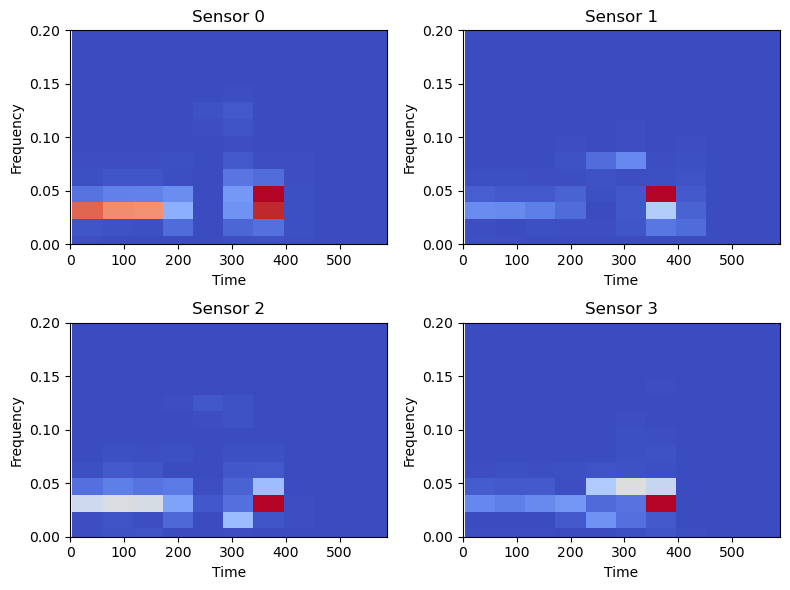

In [7]:
def plot_spectrogram(machine=0, percent=20, segment_size=64):

    data = pd.read_csv("data/machine_"+str(machine)+".csv", index_col=0)
    clean_data = smooth_data(remove_spikes(data))

    fig, ax = plt.subplots(2, 2, figsize=(8, 6))

    for i in range(4):
        f, t, Sxx = signal.spectrogram(clean_data[str(i)], nperseg=segment_size)

        ax[i//2, i%2].pcolormesh(t, f, Sxx, shading='nearest', cmap="coolwarm")
        ax[i//2, i%2].set_ylabel('Frequency')
        ax[i//2, i%2].set_xlabel('Time')
        ax[i//2, i%2].set_xlim(0, t[-1]*percent/100)
        ax[i//2, i%2].set_ylim(0, 0.2)
        ax[i//2, i%2].set_title('Sensor '+str(i))
        
    plt.tight_layout()
    plt.show()

plot_spectrogram(machine=0, percent=20, segment_size=64)

As expected, we see from the spectrogram that the signal is almost "monochromatic" in the normal mode of operation. <br />

We might expect that the machine starts out in the normal state, so one of the simplest things to do would be to calculate how "far" the spectrogram is from the initial stages of operation. We can set a threshold for the error or distance from the inital state, beyond which we say the system is in the faulty/failed state. <br />

Before we do that, let's rescale all the amplitudes so that for each sensor, amplitudes are relative to the maximum intial amplitude for that sensor. We want to do this because different sensors have different scales for the signal. We can simply calculate the L2 norm between the rescaled spectrogram at a certain time and the initial state and use this as the error metric.

### Functions to calculate spectrogram and rescale it

In [8]:
def spectrogram_data(data:pd.DataFrame, segment_length=64)->pd.DataFrame:
    
    spectra = []

    for sensor in data.columns:
        #calculate the spectrogram for each sensor and add it to a dataframe
        f, t, Sxx = signal.spectrogram(data[sensor], nperseg=segment_length)

        index = pd.Series(t.astype(int), name="time")
        columns = pd.MultiIndex.from_tuples([(sensor, x) for x in f], names=["sensor", "frequency"])

        spectra.append(pd.DataFrame(Sxx.T, index=index, columns=columns))

    return pd.concat(spectra, axis=1)


def rescale_spec_data(spec_data:pd.DataFrame)->pd.DataFrame:

    rescaled_data = spec_data.copy()

    for sensor in spec_data.columns.unique(0):
        rescaled_data[sensor] /= (rescaled_data[sensor].iloc[0].max())

    return rescaled_data

### Visualize the error function

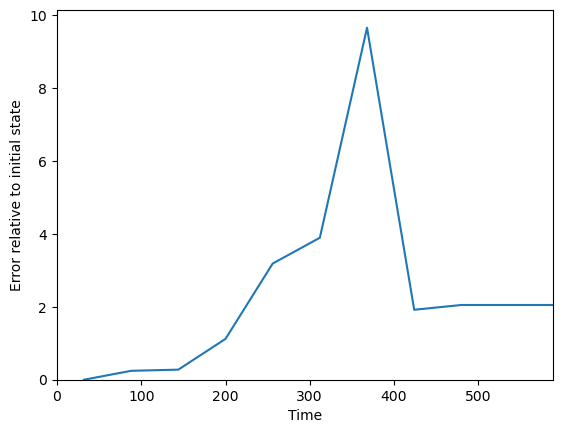

In [9]:
def plot_spectrogram_error(machine=0, percent=20):

    data = pd.read_csv("data/machine_"+str(machine)+".csv", index_col=0)
    clean_data = smooth_data(remove_spikes(data))

    rescaled_data = rescale_spec_data(spectrogram_data(clean_data))

    X = rescaled_data.values
    plt.plot(rescaled_data.index, np.linalg.norm(X-X[0], axis=1))
    plt.xlim(0, rescaled_data.index[-1]*percent/100)
    plt.ylim(0)
    plt.xlabel("Time")
    plt.ylabel("Error relative to initial state")

plot_spectrogram_error(machine=0, percent=20)

Looking through these, we see that a threshold of 1 would work well. In most cases, this is also half the error between the inital and failure state. Here is the full pipeline with this approach

In [10]:
def detect_faults(data, window=10, segment_length=64, threshold=1):
    
    # a function that returns the times of the detected faults

    clean_data = smooth_data(remove_spikes(data), window=window)
    spec_data = spectrogram_data(clean_data, segment_length=segment_length)
    rescaled_data = rescale_spec_data(spec_data)
    error = np.linalg.norm(rescaled_data-rescaled_data.iloc[0], axis=1)

    return list(rescaled_data.index[error > threshold])

### Visualize the modes of operation

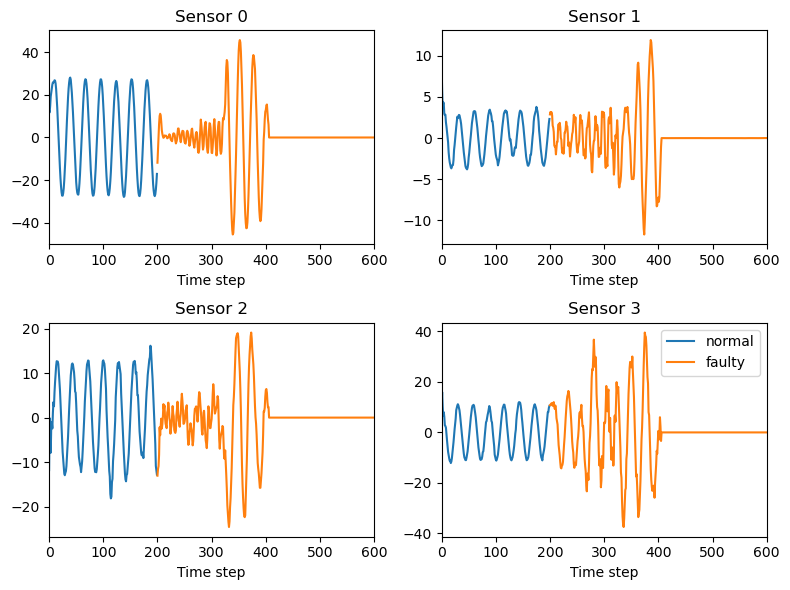

In [11]:
def plot_data_with_faults(machine=0,percent=20):

    data = pd.read_csv("data/machine_"+str(machine)+".csv", index_col=0)

    faults = detect_faults(data)
    if faults:
        time = min(faults)
    else:
        time=len(data)

    clean_data = smooth_data(remove_spikes((data)))

    #plot
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))
    

    for i in range(4):
        ax[i//2, i%2].plot(range(time), clean_data.iloc[:int(time)][str(i)], label='normal')
        ax[i//2, i%2].plot(range(time, len(data)), clean_data.iloc[int(time):][str(i)], label='faulty')

        # ax[i//2, i%2].plot(range(len(data)), clean_data[str(i)])
        ax[i//2, i%2].set_xlim(0, len(data)*percent/100)
        ax[i//2, i%2].set_xlabel('Time step')
        ax[i//2, i%2].set_title('Sensor '+str(i))
        
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_data_with_faults(machine=0, percent=20)

This approach seems to work quite well for all the machines we have! <br />
The major drawback of this approach is that it is quite specific to the fact that the normal state of these machines has this particular oscillatory behavior. <br />
A more generic approach would be as follows: 
* Assume all machines of a similar kind have a similar normal state and that we have data for these
* Assume that for some initial window of time all these machines operate in the normal state
* Train a model that either predicts the future states or reconstructs the present state
* Measure the error between this prediction/reconstruction and the actual values
* If this crosses a threshold we have a faulty/broken machine

# Approach 2: regression

We can create a sliding window of some fixed size and use the sensor data in that window to predict some future readings. If the model is only trained for the normal mode of operation, we might expect that the model performs badly in the other modes of operation. 

## Process data

First let's create a dataset that has the features and labels. We simply create a moving window over the signals and use those as the features to predict the next few time steps

In [12]:
def process_regression_data(data, start=10, end=110, step=10, pred_size=2):

    clean_data = smooth_data(remove_spikes(data), start)

    X, y = [], []

    for i in range(start, (end//step)*step):
        X.append(clean_data.values[i : i+step].flatten())
        y.append(clean_data.values[i+step : i+step+pred_size].flatten())
    
    return np.array(X), np.array(y)

Let's stick to machine 0  for now. First we establish a baseline MSE by simply predicting the last value

In [13]:
start, end, step, pred_size = 10, 110, 10, 2

data = pd.read_csv("data/machine_0.csv", index_col=0)
X, y = process_regression_data(data, start, end, step, pred_size)

y_pred = np.tile(X[:, -4:], pred_size)

print("Baseline MSE: ", mean_squared_error(y, y_pred)/pred_size)

Baseline MSE:  8.016965736892532


### Linear model

Let's see if we can improve the baseline MSE by building a simple linear model

In [14]:
pipe = make_pipeline(StandardScaler(), LinearRegression())

pipe.fit(X, y)

y_pred = pipe.predict(X)

print("Linear model MSE: ", mean_squared_error(y, y_pred)/pred_size)

Linear model MSE:  0.05683105403894098


That's a massive improvement in the MSE. Now let's generate predictions for the rest of the time series to see how we do

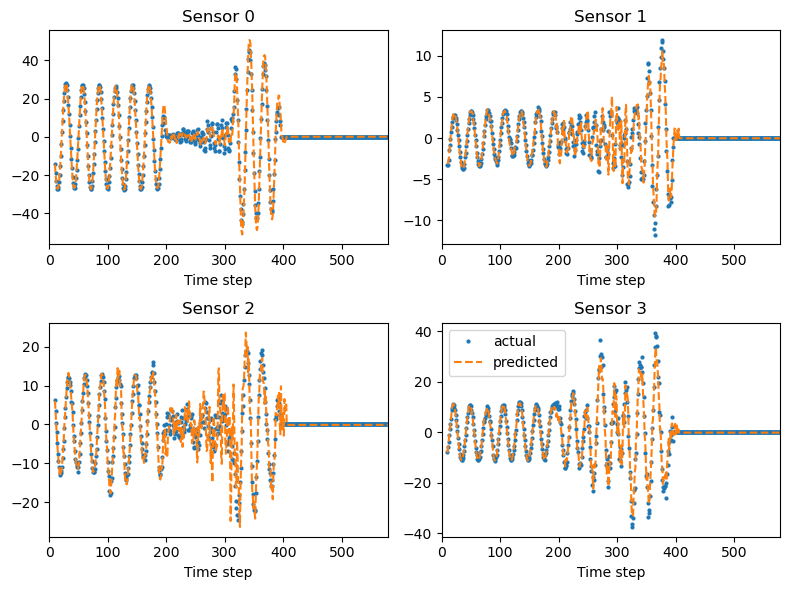

In [15]:
X_test, y_test = process_regression_data(data, start=start, end=2900, step=step, pred_size=pred_size)
y_pred = pipe.predict(X_test)

def plot_linear_model(percent=20):

    #plot
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))

    for i in range(4):
        ax[i//2, i%2].plot(range(start, start+len(y_pred)), y_test[:, i], ls='', marker='o', ms=2, label="actual")
        ax[i//2, i%2].plot(range(start, start+len(y_pred)), y_pred[:, i], ls='--', label="predicted")
        ax[i//2, i%2].set_xlim(0, len(y_pred)*percent/100)
        ax[i//2, i%2].set_xlabel('Time step')
        ax[i//2, i%2].set_title('Sensor '+str(i))
    
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_linear_model(percent=20)

As expected, we do quite well in the normal mode, but not so, in the faulty mode. We can once again set a threshold for the error to find where the faulty behavior occurs. Here is the whole thing.

In [16]:
def detect_faults_regression(data, model, threshold=20, **kwargs):
    #Function to detect faults using regression that resturns the earliest time a machine enters the faulty mode

    #process regression data (include smoothing)
    X_train, y_train = process_regression_data(data, **kwargs)

    kwargs['end'] = 2950
    X_test, y_test = process_regression_data(data, **kwargs)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    errors = np.average((y_pred-y_test)**2, axis=1)/(y_test.shape[1]/4)
    start = kwargs.get("start", 10)
    ind = np.arange(start, kwargs["end"])[errors > threshold]

    if len(ind)==0:
        time = len(data)
    else:
        time = start+ind[0]

    return time



def plot_faults(data, time, percent=50):
    #Plot the data where time is the earliest detected fault
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))
    

    for i in range(4):
        ax[i//2, i%2].plot(range(time), data.iloc[:int(time)][str(i)], label='normal')
        ax[i//2, i%2].plot(range(time, len(data)), data.iloc[int(time):][str(i)], label='faulty')

        ax[i//2, i%2].set_xlim(0, len(data)*percent/100)
        ax[i//2, i%2].set_xlabel('Time step')
        ax[i//2, i%2].set_ylabel('Sensor value')
        ax[i//2, i%2].set_title('Sensor '+str(i))
    
    plt.legend()
    plt.tight_layout()
    plt.show()

LinearRegression()


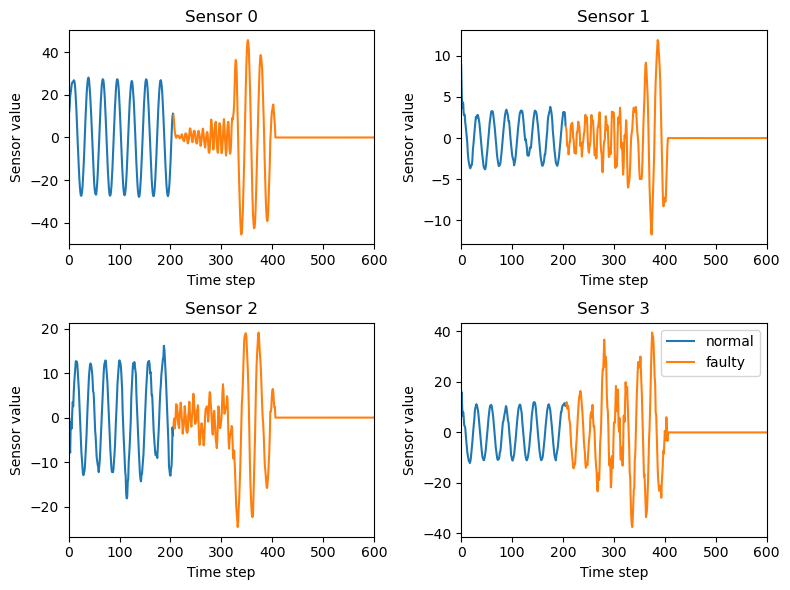

In [17]:
def plot_regression_model_results(machine=0, model=LinearRegression(), percent=20, **kwargs):

    data = pd.read_csv("data/machine_"+str(machine)+".csv", index_col=0)
    clean_data = smooth_data(remove_spikes(data))

    time = detect_faults_regression(data, model, **kwargs)

    print(model)
    plot_faults(clean_data, time, percent)

    return

plot_regression_model_results(machine=0, model=LinearRegression(), percent=20)

Even a linear model is able to do very well in detecting the beginning of the fauly mode! Let's try something a little more complex, just for fun.

## Random forest

Let's do this with another regression model, but we'll skip over the details

RandomForestRegressor(max_features=0.5, min_samples_leaf=2)


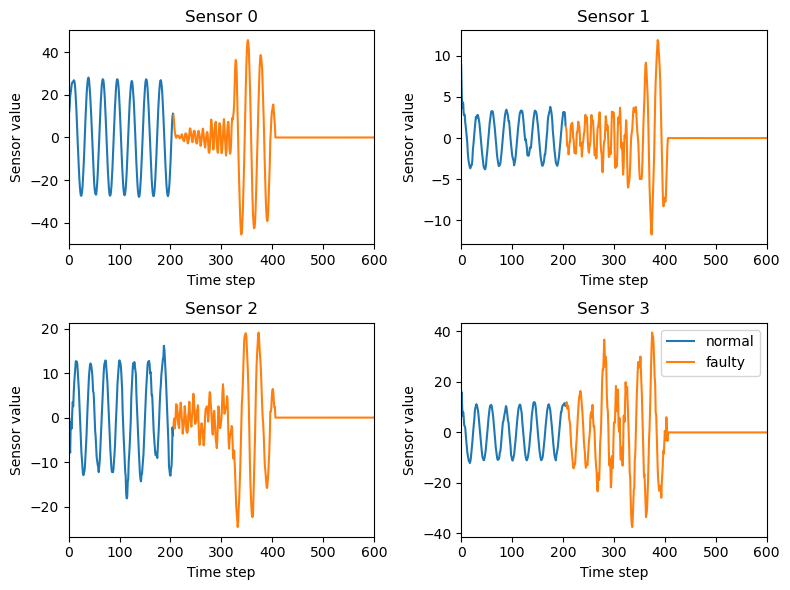

In [18]:
plot_regression_model_results(machine=0, model=RandomForestRegressor(n_estimators=100, max_features=0.5, min_samples_leaf=2), percent=20)

This works pretty well too!

In summary, we built a regression model trained on the initial stages of the time series (where it is assumed to operate normally) to predict a few values in the future. We saw that the models work well in predicting the values in the normal mode, but have large errors in the faulty mode. This enables us to detect the faulty mode as the region with a large prediction error. This approach is more general than approach 1 since we can train an arbitrary time series with an appropriate model.

# Approach 3: autoencoder / state reconstruction

Similar to the last approach, let's train a model that can encode then decode the state in the normal mode. Once again, the assumption is that this model will perform badly in reconstructing the state in the faulty mode. This approach is quite similar to the previous one, so I won't elaborate on the details so much.

### Data processing

We can use the same method as the regression models to get the training data, except here the targets are identical to the features. We also scale the inputs to have zero mean and unit variance

In [19]:
start, end, step, pred_size = 10, 120, 10, 2

data = pd.read_csv("data/machine_0.csv", index_col=0)
clean_data = smooth_data(remove_spikes(data), window=start)

X, _ = process_regression_data(data, start, end, step, pred_size)

scaler = StandardScaler()
X = scaler.fit_transform(X)

## Model building and training

Our model can simply consist of a dense layer that takes the inputs and encodes them in a smaller dimension (in this case we go from 40->10) and an output dense layer that reconstructs the inputs.

In [20]:
encoder = tf.keras.Sequential([
                                tf.keras.Input(shape=(X.shape[1],)),
                                tf.keras.layers.Dense(units=10, activation='selu'),
                                tf.keras.layers.Dropout(0.2)
                                ])

decoder = tf.keras.Sequential([
                                tf.keras.layers.Dense(units=X.shape[1], input_shape=(encoder.output_shape[1], ), activation='linear')
                                ])


model = tf.keras.Sequential([encoder, decoder])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse")

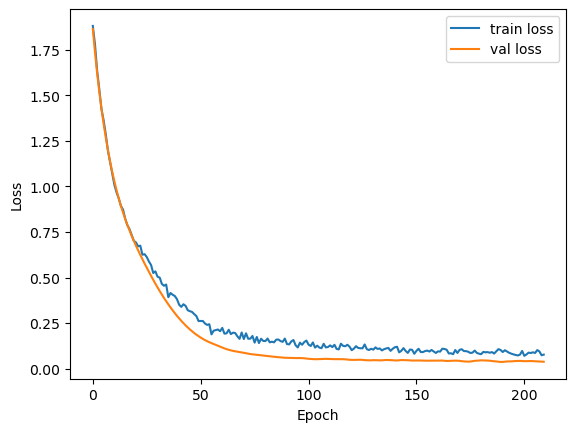

In [21]:
history = model.fit(X, X, 
                    epochs=1000, validation_split=0.2, 
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
                    verbose=0
                    )


plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

Looks like training has converged

## Visualize the results

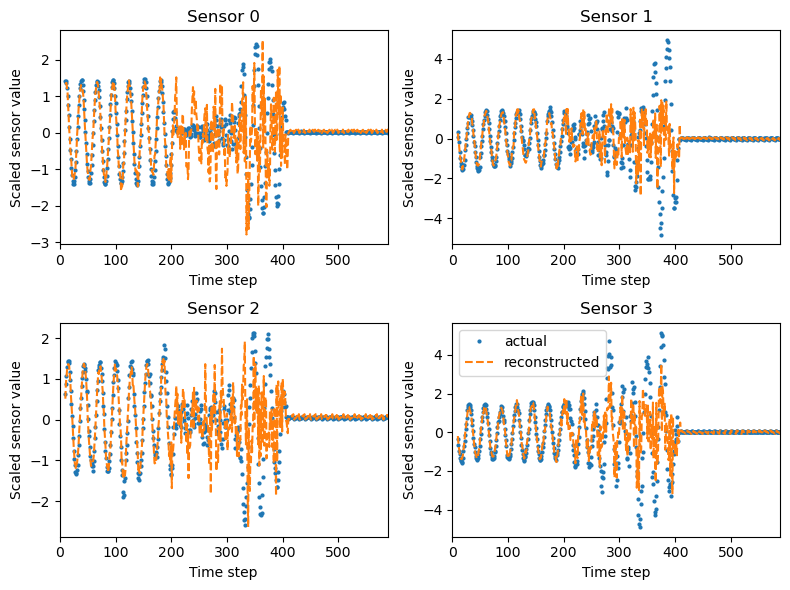

In [22]:
start, end = 10, 2950

X_test, _ = process_regression_data(data, start, end)
X_test = scaler.transform(X_test)

X_pred = model.predict(X_test, verbose=0)

def plot_reconstruction(percent=20):

    #plot
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))

    y_test = X_test[::step].reshape(-1, 4)
    y_pred = X_pred[::step].reshape(-1, 4)

    for i in range(4):
        ax[i//2, i%2].plot(range(start, start+len(y_pred)), y_test[:, i], ls='', marker='o', ms=2, label="actual")
        ax[i//2, i%2].plot(range(start, start+len(y_pred)), y_pred[:, i], ls='--', label="reconstructed")
        ax[i//2, i%2].set_xlim(0, len(y_pred)*percent/100)
        ax[i//2, i%2].set_xlabel('Time step')
        ax[i//2, i%2].set_ylabel('Scaled sensor value')
        ax[i//2, i%2].set_title('Sensor '+str(i))
    
    plt.legend()
    plt.tight_layout()
    plt.show();

plot_reconstruction(percent=20)

The results are quite similar to the regression models, so we can use a similar threshold for the reconstruction error to detect the faulty mode

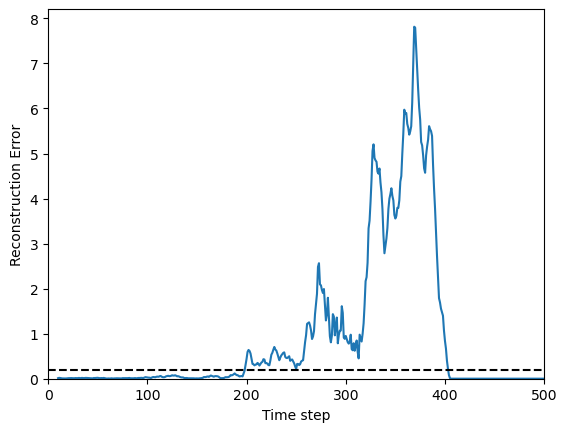

In [23]:
plt.plot(range(start, start+len(X_test)), np.average((X_test-X_pred)**2, axis=1))
plt.axhline(0.2, color='k', ls='--')
plt.xlabel('Time step')
plt.ylabel('Reconstruction Error');
plt.xlim(0, 500);
plt.ylim(0);

In this case, a threshold around 0.5 should do well

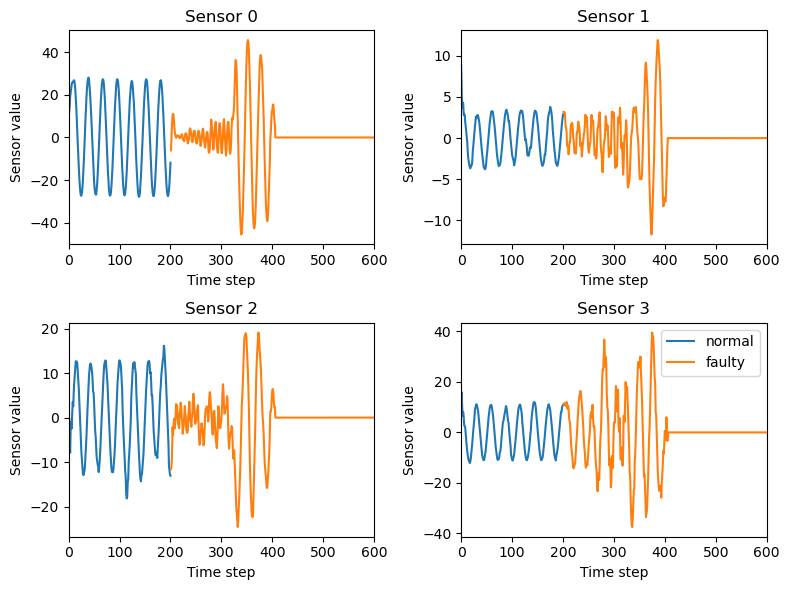

In [24]:
threshold=0.5

time = np.arange(start, start+len(X_test))[np.average((X_test-X_pred)**2, axis=1) > threshold][0]

plot_faults(clean_data, time, percent=20)

This approach is also quite general, and we can potentially use more complicated models, if required